In [1]:
import json
import math

from utils import read_lines

In [2]:
PATH = json.load(open('../path_config.json'))

#### Read XSum

In [3]:
document_path = PATH['xsum_fariseq'] + '/test.source'
target_path = PATH['xsum_fariseq'] + '/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Evaluate Annotated Dataset

In [4]:
from tqdm import tqdm

In [5]:
data = json.load(open('../data/annotated_with_probability_200.json', 'r'))
print(len(data))

200


In [6]:
data[55]

{'id': 10943,
 'pred': "A powerful cyclone has killed at least 11 people and injured more than 100 in Vanuatu, the Pacific nation's president has said.",
 'ents': [{'start': 30,
   'end': 41,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'at least 11',
   'bart.large': 0.0215301513671875,
   'xsum_cmlm_bos': 0.02984619140625,
   'bart.large.xsum': 0.0200347900390625,
   'cnndm_cmlm_cedar': 0.007183074951171875,
   'cnndm_cmlm_scratch_cedar_warmup_10000': 1.9073486328125e-06,
   'xsum_cmlm_scratch_cedar_warmup_20000': 0.092529296875},
  {'start': 61,
   'end': 74,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'more than 100',
   'bart.large': 0.05804443359375,
   'xsum_cmlm_bos': 0.0843505859375,
   'bart.large.xsum': 0.06317138671875,
   'cnndm_cmlm_cedar': 0.01030731201171875,
   'cnndm_cmlm_scratch_cedar_warmup_10000': 4.7087669372558594e-05,
   'xsum_cmlm_scratch_cedar_warmup_20000': 0.003948211669921875},
  {'start': 78,
   'end': 85,
   'label': 0,
   'type': 'GPE',
   'ent': 

#### Prior/Posterior Distribution Diagram

In [7]:
%matplotlib inline

from draw import plot_scatter

In [65]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        e['prior'] = e['bart.large']
        e['posterior'] = e['xsum_cmlm_bos']
        prior_posterior.append(e)

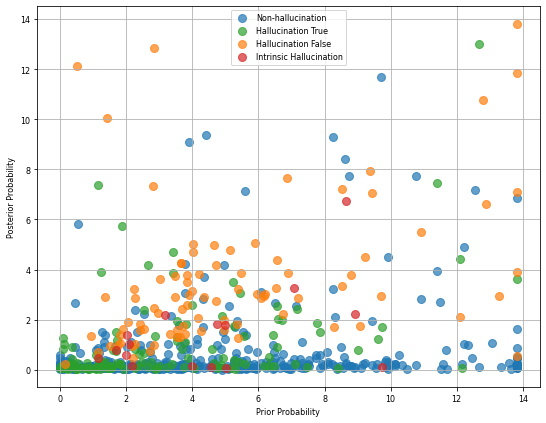

In [67]:
input_data = [
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]
]

input_data_log_scale = [[], [], [], []]
for i in range(len(input_data)):
    for p in input_data[i]:
        prior, posterior = max(p[0], 1e-6), max(p[1], 1e-6)
        input_data_log_scale[i].append((-math.log(prior), -math.log(posterior)))
        
labels = ['Non-hallucination', 'Hallucination True', 'Hallucination False', 'Intrinsic Hallucination']
plot_scatter(input_data_log_scale, labels)

#### Compare CMLM

In [10]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['text.usetex'] = False

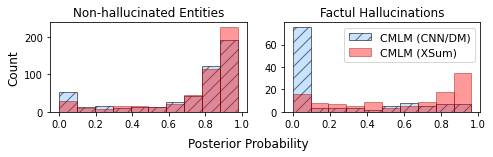

In [11]:
n_bins = 10
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.0))

my_blue = (153/255, 204/255, 1.0, 0.55)
my_edge = (0., 0., 0., 0.55)

priors_0 = [p['prior'] for p in prior_posterior if p['label'] == 0]
posteriors_0 = [p['posterior'] for p in prior_posterior if p['label'] == 0]
_, bins, _ = ax0.hist(priors_0, n_bins, density=False, histtype='bar', label='CMLM trained on CNN/DM',
                      facecolor=my_blue, edgecolor=my_edge, hatch='//')
ax0.hist(posteriors_0, bins=bins, density=False, histtype='bar',
         facecolor='red', label='CMLM trained on XSum', edgecolor='darkred', alpha=0.40)
ax0.set_ylabel('Count', fontsize=12)
ax0.set_title('Non-hallucinated Entities', fontsize=12)

priors_1 = [p['prior'] for p in prior_posterior if p['label'] == 1]
posteriors_1 = [p['posterior'] for p in prior_posterior if p['label'] == 1]
_, bins, _ = ax1.hist(priors_1, n_bins, density=False, histtype='bar', 
                      facecolor=my_blue, label='CMLM (CNN/DM)', edgecolor=my_edge, hatch='//')
ax1.hist(posteriors_1, bins=bins, density=False, histtype='bar',
         facecolor='red', label='CMLM (XSum)', edgecolor='darkred', alpha=0.40)
ax1.legend(prop={'size': 11})
ax1.set_title('Factul Hallucinations', fontsize=12)

fig.text(0.5, -0.05, 'Posterior Probability', ha='center', fontsize=12)
# fig.text(0.0, 0.5, 'Count', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()

plt.savefig("figures/" + 'hist_2cmlm' +'.pdf', bbox_inches="tight")
plt.show()

In [12]:
# selected_entities = []
# for e in prior_posterior:
#     if e['label'] == 1:
#         if e['prior'] > 1e-5 and math.log(e['posterior'] / e['prior']) > 5:
#             selected_entities.append(e)
#         if e['prior'] > 0. and math.log(e['posterior'] / e['prior']) < 0:
#             selected_entities.append(e)
#         elif e['posterior'] - e['prior'] > 0.5:
#             selected_entities.append(e)

In [13]:
# print(len(selected_entities))
# print(selected_entities[0])

In [14]:
# json.dump(selected_entities, open('sigma_entities.json', 'w'))

#### Get Average Entropy

In [15]:
import math

from draw import plot_hist

In [16]:
for l in range(3):
    posteriors = [p['prior'] for p in prior_posterior if p['label'] == l]
    print('- label {}: {}'.format(l, -math.log(sum(posteriors) / len(posteriors))))

- label 0: 0.3592518706138053
- label 1: 1.4271219341161852
- label 2: 2.679684229372208


In [17]:
threshold = 0.0001
posteriors = [[], [], []]
for l in range(3):
    for p in prior_posterior:
        if p['label'] == l and p['posterior'] > threshold:
            posteriors[l].append(p['posterior'])

In [18]:
threshold = 1e-7
priors= [[], [], []]
for l in range(3):
    for p in prior_posterior:
        if p['label'] == l and p['prior'] > threshold:
            priors[l].append(p['prior'])

In [19]:
# plot_hist('histogram', posteriors, priors, save_fig=True)

#### Evaluate Baseline Models

In [20]:
from sklearn.metrics import classification_report

In [21]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'bart.large': 1.1265277862548828e-05,
 'xsum_cmlm_bos': 0.019073486328125,
 'bart.large.xsum': 0.0927734375,
 'cnndm_cmlm_cedar': 0.80859375,
 'cnndm_cmlm_scratch_cedar_warmup_10000': 0.00147247314453125,
 'xsum_cmlm_scratch_cedar_warmup_20000': 0.01239013671875,
 'id': 8805,
 'prior': 0.80859375,
 'posterior': 0.019073486328125}

In [22]:
true_label, factual_label, hallucination_label = [], [], []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        if p['label'] == 0 or p['label'] == 1:
            factual_label.append(1)
        elif p['label'] == 2:
            factual_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        if p['label'] == 0:
            hallucination_label.append(0)
        elif p['label'] == 2 or p['label'] == 1:
            hallucination_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        true_label.append(p['label'])
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [23]:
lm_baseline_preds = []
overlap_preds = []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            overlap_preds.append(1)
        else:
            overlap_preds.append(0)

        if p['posterior'] > p['prior']:
            lm_baseline_preds.append(1)
        else:
            lm_baseline_preds.append(0)

In [24]:
print(classification_report(factual_label, overlap_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.3517    0.9326    0.5108        89
     Factual     0.9873    0.7524    0.8540       618

    accuracy                         0.7751       707
   macro avg     0.6695    0.8425    0.6824       707
weighted avg     0.9073    0.7751    0.8108       707



In [25]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], overlap_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.8390    0.9519    0.8919       208
    Hallucinated     0.9788    0.9238    0.9505       499

        accuracy                         0.9321       707
       macro avg     0.9089    0.9379    0.9212       707
    weighted avg     0.9376    0.9321    0.9333       707



In [26]:
print(classification_report(factual_label, lm_baseline_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.0785    0.2135    0.1148        89
     Factual     0.8495    0.6392    0.7295       618

    accuracy                         0.5856       707
   macro avg     0.4640    0.4263    0.4221       707
weighted avg     0.7524    0.5856    0.6521       707



In [27]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], lm_baseline_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.1405    0.1635    0.1511       208
    Hallucinated     0.6258    0.5832    0.6037       499

        accuracy                         0.4597       707
       macro avg     0.3832    0.3733    0.3774       707
    weighted avg     0.4830    0.4597    0.4706       707



### KNN Evaluation

In [28]:
import numpy as np
import matplotlib

from sklearn import neighbors
from draw import plot, plot_three, plot_three_with_boundary

In [29]:
def leave_one_out_error(prior_probs, posterior_probs, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [30]:
n = 20
hallucination_label_reverse = [1 if i == 0 else 0 for i in hallucination_label]
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, hallucination_label_reverse, n_neighbors=n)
print(classification_report(hallucination_label_reverse, knn_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.7072    0.7548    0.7302       208
Non-hallucinated     0.8948    0.8697    0.8821       499

        accuracy                         0.8359       707
       macro avg     0.8010    0.8123    0.8062       707
    weighted avg     0.8396    0.8359    0.8374       707



In [31]:
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, factual_label, n_neighbors=20)
print(classification_report(factual_label, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.5888    0.7079    0.6429        89
     Factual     0.9567    0.9288    0.9425       618

    accuracy                         0.9010       707
   macro avg     0.7727    0.8183    0.7927       707
weighted avg     0.9104    0.9010    0.9048       707



In [32]:
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, true_label, n_neighbors=20)
print(classification_report(true_label, knn_preds, target_names=['Non-hallucinated', 'Factual', 'Non-factual'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.8660    0.8938    0.8797       499
         Factual     0.5342    0.3277    0.4062       119
     Non-factual     0.5966    0.7978    0.6827        89

        accuracy                         0.7864       707
       macro avg     0.6656    0.6731    0.6562       707
    weighted avg     0.7763    0.7864    0.7752       707



#### KNN with More Features

In [33]:
def leave_one_out_error_three_features(prior_probs, posterior_probs, overlaps, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels) == len(overlaps)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j], overlaps[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')
        
#         x_mat = np.array(train_features)
#         y_vec = np.array(train_labels)
#         classifier.fit(x_mat, y_vec)

#         test_features = np.array([[prior_probs[i], posterior_probs[i], overlaps[i]]])
        
        x_mat = np.array(train_features)
        stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
        x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i] / stds[0],
                                   posterior_probs[i] / stds[1],
                                   overlaps[i]] / stds[2]])
        
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [34]:
knn_preds = leave_one_out_error_three_features(prior_probabilities, posterior_probabilities, overlap_preds, hallucination_label_reverse, n_neighbors=15)
print(classification_report(hallucination_label_reverse, knn_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.8383    0.9471    0.8894       208
Non-hallucinated     0.9767    0.9238    0.9495       499

        accuracy                         0.9307       707
       macro avg     0.9075    0.9355    0.9195       707
    weighted avg     0.9360    0.9307    0.9318       707



In [35]:
knn_preds = leave_one_out_error_three_features(prior_probabilities, posterior_probabilities, overlap_preds, factual_label, n_neighbors=15)
print(classification_report(factual_label, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.6522    0.5056    0.5696        89
     Factual     0.9310    0.9612    0.9459       618

    accuracy                         0.9038       707
   macro avg     0.7916    0.7334    0.7577       707
weighted avg     0.8959    0.9038    0.8985       707



In [36]:
knn_preds = leave_one_out_error_three_features(prior_probabilities, posterior_probabilities, overlap_preds, true_label, n_neighbors=15)
print(classification_report(true_label, knn_preds, target_names=['Non-hallucinated', 'Factual', 'Non-factual'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.9705    0.9238    0.9466       499
         Factual     0.6447    0.8235    0.7232       119
     Non-factual     0.6750    0.6067    0.6391        89

        accuracy                         0.8670       707
       macro avg     0.7634    0.7847    0.7696       707
    weighted avg     0.8785    0.8670    0.8703       707



#### SVM with RBF Kernel

In [37]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [38]:
def leave_one_out_error_svm(prior_probs, posterior_probs, labels, linear=False):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
        
        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        
        if linear:
            clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
        else:
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = clf.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [39]:
def leave_one_out_error_svm_three_features(prior_probs, posterior_probs, overlaps, labels, linear=False):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j], overlaps[j]])
                train_labels.append(labels[j])
        
        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        
        if linear:
            clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
        else:
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i], overlaps[i]]])
        Z = clf.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [40]:
def save_svm(posterior_probs, prior_probs, overlaps, labels, linear=False):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    x_mat = np.array([posterior_probs, prior_probs, overlaps]).transpose()
    y_vec = np.array(labels)

    if linear:
        clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
    else:
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(x_mat, y_vec)

    return clf

In [41]:
svm_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, factual_label)
print(classification_report(factual_label, svm_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.6154    0.7191    0.6632        89
 Non-factual     0.9585    0.9353    0.9468       618

    accuracy                         0.9081       707
   macro avg     0.7870    0.8272    0.8050       707
weighted avg     0.9153    0.9081    0.9111       707



In [42]:
svm_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, hallucination_label_reverse)
print(classification_report(hallucination_label_reverse, svm_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.7035    0.7644    0.7327       208
Non-hallucinated     0.8981    0.8657    0.8816       499

        accuracy                         0.8359       707
       macro avg     0.8008    0.8151    0.8072       707
    weighted avg     0.8409    0.8359    0.8378       707



In [43]:
svm_preds = leave_one_out_error_svm_three_features(prior_probabilities, posterior_probabilities, overlap_preds, hallucination_label_reverse)
print(classification_report(hallucination_label_reverse, svm_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.8390    0.9519    0.8919       208
 Non-factual     0.9788    0.9238    0.9505       499

    accuracy                         0.9321       707
   macro avg     0.9089    0.9379    0.9212       707
weighted avg     0.9376    0.9321    0.9333       707



In [44]:
svm_classifier = save_svm(posterior_probabilities, prior_probabilities, overlap_preds, factual_label)

In [45]:
# pickle.dump(svm_classifier, open('classifiers/svm_classifier.pkl', 'wb'))

#### Linear Model

In [46]:
linear_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, factual_label, linear=True)
print(classification_report(factual_label, linear_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.4730    0.3933    0.4294        89
 Non-factual     0.9147    0.9369    0.9257       618

    accuracy                         0.8685       707
   macro avg     0.6938    0.6651    0.6776       707
weighted avg     0.8591    0.8685    0.8632       707



In [47]:
linear_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, hallucination_label_reverse, linear=True)
print(classification_report(hallucination_label_reverse, linear_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.6599    0.6250    0.6420       208
Non-hallucinated     0.8471    0.8657    0.8563       499

        accuracy                         0.7949       707
       macro avg     0.7535    0.7454    0.7491       707
    weighted avg     0.7920    0.7949    0.7932       707



In [48]:
linear_preds = leave_one_out_error_svm_three_features(prior_probabilities, posterior_probabilities, overlap_preds, hallucination_label_reverse, linear=True)
print(classification_report(hallucination_label_reverse, linear_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.8407    0.9135    0.8756       208
 Non-factual     0.9626    0.9279    0.9449       499

    accuracy                         0.9236       707
   macro avg     0.9016    0.9207    0.9102       707
weighted avg     0.9267    0.9236    0.9245       707



#### KNN Classification Boundaries

In [49]:
font = {'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

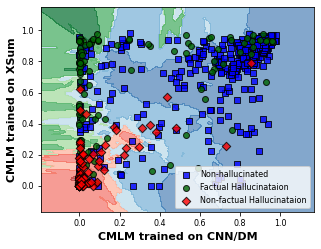

In [50]:
plot_three_with_boundary('entity_distribution_2cmlm',
                         posterior_probabilities, prior_probabilities, true_label,
                         colors=['blue', 'darkgreen', 'red'],
                         legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion'],
                         x_label='CMLM trained on CNN/DM',
                         y_label='CMLM trained on XSum',
                         n_neighbors=16,
                         fig_size=(4.5, 3.5),
                         interval=0.25, h=0.05,
                         save_figure=True)

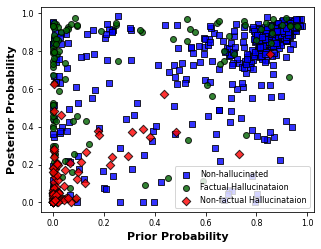

In [51]:
plot_three('entity_distribution_mlm_cmlm',
           posterior_probabilities, prior_probabilities, true_label,
           colors=['blue','darkgreen', 'red'],
           x_label='Prior Probability',
           y_label='Posterior Probability',
           legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion'],
           n_neighbors=10,
           fig_size=(4.5, 3.5),
           save_figure=True)

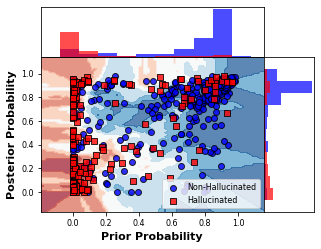

In [52]:
plot('hallucination_class',
     posterior_probabilities, prior_probabilities, [1 if i == 0 else 0 for i in hallucination_label], 
     n_neighbors=12, fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Hallucinated', 'Non-Hallucinated'], save_figure=True)

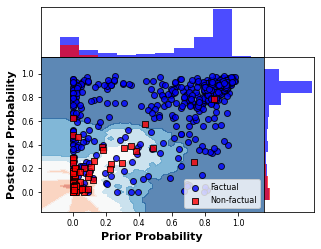

In [53]:
plot('factuality_class', posterior_probabilities, prior_probabilities, factual_label, n_neighbors=20, 
     fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Non-factual', 'Factual'],
     x_label='Prior Probability', y_label='Posterior Probability', save_figure=True)

#### Save KNN Model

In [54]:
import pickle

In [55]:
def build_KNN(posteriors, priors, labels, overlaps=None, n_neighbors=15):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    priors = np.array(priors)
    posteriors = np.array(posteriors)
    
#     x_mat = np.vstack([posteriors / np.std(posteriors), priors / np.std(priors)]).transpose()
    if overlaps is not None:
        overlaps = np.array(overlaps)
        x_mat = np.vstack([posteriors, priors, overlaps]).transpose()
    else:
        x_mat = np.vstack([posteriors, priors]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat, y_vec)
    
    return classifier

In [56]:
knn_classifier = build_KNN(posterior_probabilities, prior_probabilities, factual_label, overlaps=overlap_preds, n_neighbors=15)

In [57]:
preds = knn_classifier.predict(np.array(np.vstack([posterior_probabilities, prior_probabilities, overlap_preds]).transpose()))

In [58]:
print(classification_report(factual_label, preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.6698    0.7978    0.7282        89
     Factual     0.9700    0.9434    0.9565       618

    accuracy                         0.9250       707
   macro avg     0.8199    0.8706    0.8424       707
weighted avg     0.9323    0.9250    0.9278       707



In [59]:
pickle.dump(knn_classifier, open('classifiers/knn_mlm_cmlm_3.pkl', 'wb'))

#### AUC

In [60]:
from draw import draw_auc

In [61]:
p1, p2, p3, p4, p5, p6, p7 = [], [], [], [], [], [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        p1.append(p['bart.large'])
        p2.append(p['xsum_cmlm_bos'])
        p3.append(p['xsum_cmlm_scratch_cedar_warmup_20000'])
        p4.append(p['cnndm_cmlm_cedar'])
        p5.append(p['cnndm_cmlm_scratch_cedar_warmup_10000'])
        p6.append(p['bart.large.xsum'])
#         p7.append(p['bart.large.cnn'])

assert len(p1) == len(factual_label)

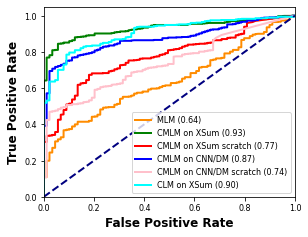

In [62]:
draw_auc(factual_label,
         [p1, p2, p3, p4, p5, p6],
         ['MLM', 'CMLM on XSum', 'CMLM on XSum scratch', 'CMLM on CNN/DM', 'CMLM on CNN/DM scratch', 'CLM on XSum'],
         ['darkorange', 'green', 'red', 'blue', 'pink', 'aqua'])

In [63]:
# draw_auc(factual_label,
#          [p2, p6, p4, p7],
#          ['CMLM on XSum', 'CLM on XSum', 'CMLM on CNN/DM', 'CLM on CNN/DM'],
#          ['darkorange', 'green', 'red', 'blue'])